## Assignment 10

### Brief dataset description  

The dataset consists of 569 entries of 30 numeric predictive variables and the outcome.  
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.   

#### Attribute information  
* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension (“coastline approximation” - 1)

The mean, standard error, and “worst” or largest (mean of the three worst/largest values) of these features were computed for each image, resulting in 30 features. For instance, field 0 is Mean Radius, field 10 is Radius SE, field 20 is Worst Radius.  


As found on [sklearn documentation](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset)

In [1]:
# if needed install packages by uncommenting the following lines
#!pip install yellowbrick
#!pip install tensorflow

In [2]:
import pandas as pd 
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from yellowbrick.model_selection import RFECV
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# load the data 
cancerDF = load_breast_cancer(as_frame=True)['frame']

I will be replicating the dataset preparation from assignment 2 in order to compare the results with the results of the best performing random forest.

In [4]:
# split the data into train test  
X = cancerDF[[x for x in cancerDF.columns if x!='target']]
y = cancerDF['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
scaled_df = pd.DataFrame(X_train_scaled)
scaled_df.columns = [col for col in cancerDF.columns if col!='target']
scaled_df['target'] = y_train

def violin_plot(dataset: pd.DataFrame, var_type: str) ->None:
    if var_type not in ['mean', 'error', 'worst']:
        raise ValueError('var_type parameter must be one of "ean", "error" or "worst"')

    data = dataset[[col for col in dataset.columns if var_type in col]+['target']]
    data = pd.melt(data, id_vars="target", var_name="features", value_name='value')
    plt.figure(figsize=(10,5))
    sns.violinplot(x="features", y="value", hue="target", data=data, split=True, inner="quart", palette='GnBu')
    plt.xticks(rotation=45)

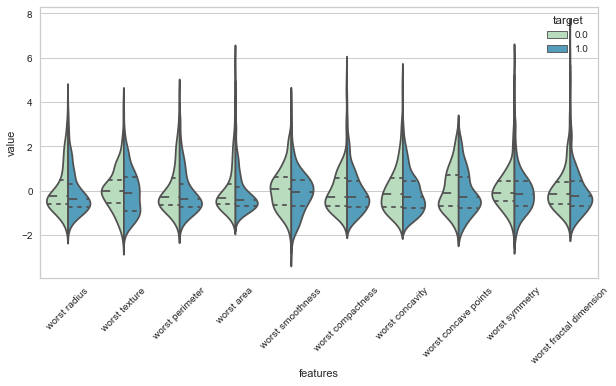

In [9]:
violin_plot(scaled_df, 'worst')

The dataset contains many features and many are correlated with each other.  
A simple and fast filter method to find the best correlated features with the output variable is used.

In [10]:
feat_selector = SelectKBest(k=8)
X_train_selected = feat_selector.fit_transform(X_train_scaled, y_train)
X_test_selected = feat_selector.transform(X_test_scaled)

# also keep the names of the features used 
names=[x for x,y in zip(cancerDF.columns, feat_selector.get_support()) if y]

In [13]:
# best model of assignment 2
rf = RandomForestClassifier(n_estimators=86, criterion='gini', n_jobs=-1)
rf.fit(X_train_selected, y_train)
y_hat = rf.predict(X_test_selected)
accuracy_score(y_test, y_hat)

0.9649122807017544

Ensemble modeling in machine learning is practicaly the combination of predictions from multiple models in order to generate a final model which provide better overall performance.  
The motivation behind this technique is to correctly combine weak models to get a more accurate and robust model.  

Depending on how the base models are combined, ensemble learning is typically classified into the following categories:
* Bagging  
Build base models independently and average their results for the final predictions. The base models can be the same but also combining different models is also possible.  
* Boosting  
Boosting models are built sequentially and try to reduce the bias on final predictions.  
* Stacking  
The predictions of each individual model are stacked together and used as input to a final estimator to compute the prediction.

In [41]:
def get_nn_model(n_inp: int) ->keras.Sequential:

    model = Sequential()
    # Adding the input layer and the first hidden layer
    model.add(Dense(units=60, kernel_initializer='uniform', activation='selu', input_dim=n_inp))
    # Adding dropout to prevent overfitting
    model.add(Dropout(rate=0.2))
    # Adding the second hidden layer
    model.add(Dense(units=12, kernel_initializer='uniform', activation='selu'))
    # Adding dropout to prevent overfitting
    model.add(Dropout(rate=0.2))
    # Adding the output layer
    model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    # Compiling the ANN
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [42]:
model = get_nn_model(X_train_selected.shape[1])
# Fitting the ANN to the Training set
model.fit(X_train_selected, y_train, validation_data=(X_test_selected, y_test), batch_size=120, epochs=120, verbose=0)

In [43]:
y_hat = model.predict(X_test_selected)
y_hat = [int((value > 0.5)[0]) for value in y_hat]
accuracy_score(y_test, y_hat)

0.9473684210526315

In [19]:
model.evaluate(X_test_selected, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 0.1243 - accuracy: 0.9474


[0.12430853396654129, 0.9473684430122375]

As random forest is a bagging technique, I will make an bagging ensemble of 2-layer neural networks.  
Bagging or bootstrap aggregation method is a statistical technique for estimating quantities about a population by averaging estimates from multiple small data samples. In the bootstrap method the samples are taken by resampling a larger sample (sampling with replacement). In this way an observation can be included in a given small sample more than once. 

In [36]:
n_examples = X_train_selected.shape[0]
random_sample_rows = np.random.choice(n_examples, size=int(n_examples*0.8), replace=True)
X_train_sampled = X_train_selected[random_sample_rows, :]

In [39]:
from tqdm import tqdm 

In [51]:
random_sample_rows

array([190, 446, 247,  15, 322, 261, 153, 303, 345, 342, 264, 279, 189,
       120, 139,  21,  10, 290,  70, 286, 139, 250, 444, 152, 301, 211,
       351, 111, 294, 261, 228, 418,   4, 181, 221, 274,   0, 383,  27,
       336,  36, 160, 180, 165,   8, 118, 141, 255, 345,  19, 386, 260,
        40, 379, 201, 115, 309, 165, 321, 345, 410, 319,  42, 146, 104,
       194, 436,  21, 146,   8, 329, 326,  85, 185, 150, 210, 292,  93,
       378, 191,  55, 372, 333, 186,  58,  66, 207, 428, 273, 308, 208,
       331,  58, 265, 279, 127, 161, 428, 343, 167, 421, 389, 398, 332,
       195, 436,   1,   0, 215, 359,  38, 376, 306, 302, 394, 439,  82,
       399, 447, 268, 231,   8, 234, 228, 111, 258, 453, 438, 286, 394,
       261, 347, 201, 276, 401, 215])

In [82]:
n_examples = X_train_selected.shape[0]
scores = []
results_df = pd.DataFrame()

for n in tqdm(range(87)):
    random_sample_rows = np.random.choice(n_examples, size=int(n_examples*0.6), replace=True)
    X_train_sampled = X_train_selected[random_sample_rows, :]
    y_train_sampled = y_train.reset_index(drop=True).iloc[random_sample_rows]
    nn = get_nn_model(X_train_sampled.shape[1])
    nn.fit(X_train_sampled, y_train_sampled, batch_size=120, epochs=120, verbose=0)
    y_pred = [int((value > 0.5)[0]) for value in nn.predict(X_test_selected)]
    results_df[f'nn_{n}'] = y_pred
    scores.append(accuracy_score(y_test, y_pred))


100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


In [83]:
results_df['ensemble_pred'] = results_df.apply(lambda x: int((sum(x)/12) > 0.5), axis=1)
accuracy_score(y_test, results_df['ensemble_pred'])

0.9473684210526315

In [81]:
np.mean(scores)

0.9473684210526315

In [73]:
results_df.drop(columns='ensemble_pred', inplace=True)